<div style='background-image: url("../../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> Lamb's problem </div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>

---

This notebook is part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.

##### Authors:
* David Vargas ([@dvargas](https://github.com/davofis))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

(Based on the original code by Lane Johnson)

## Basic Equations

The fundamental analytical solution to the three-dimensional Lamb’s problem, the problem of determining the elastic disturbance resulting from a point force in a homogeneous half space, is implemented in this Ipython notebook. This solution provides fundamental information used as benchmark for comparison with entirely numerical solutions. A setup of the fundamental problem is illustrated below. The figure on the right hand side is published in [1] (Figure 1. System of coordinates)

<p style="width:65%;float:right;padding-left:50px">
<img src=lambs_setup.png>
<span style="font-size:smaller">
</span>
</p>

Simulations of 3D elastic wave propagation need to be validated by the use of analytical solutions. In order to evaluate how healthy a numerical solution is, one may recreate conditions for which analytical solutions exist with the aim of reproducing and compare the different results.

We which to find the displacement wavefield $\mathbf{u}(\mathbf{x},t)$ at some distance $\mathbf{x}$ from a seismic  source with $ \mathbf{F} = f_1\mathbf{\hat{x}_1} + f_2\mathbf{\hat{x}_2} + f_3\mathbf{\hat{x}_3}$.

For a uniform elastic material and a Cartesian co-ordinate system the equation for the conservation of linear momentum can be written

\begin{align*}
\rho(x) \frac{\partial^2}{\partial t^2} \mathbf{u(\mathbf{x},t)} = (\lambda + \mu)\nabla(\nabla\mathbf{u(\mathbf{x},t)}) + \mu\nabla^2 \mathbf{u(\mathbf{x},t)} + \mathbf{f(\mathbf{x},t)}
\end{align*}

We will consider the case where the source function is localized in both time and space

\begin{align*}
\mathbf{f(\mathbf{x},t)} = (f_1\mathbf{\hat{x}_1} + f_2\mathbf{\hat{x}_2} + f_3\mathbf{\hat{x}_3})\delta(x_1 - x^{'}_{1})\delta(x_2 - x^{'}_{2})\delta(x_3 - x^{'}_{3})\delta(t - t^{'})
\end{align*}

For such a source we will refer to the displacement solution as a Green’s function, and use the standard notation

\begin{align*}
\mathbf{u(\mathbf{x},t)} = g_1(\mathbf{x},t;\mathbf{x^{'}},t^{'})\mathbf{\hat{x}_1} + g_2(\mathbf{x},t;\mathbf{x^{'}},t^{'})\mathbf{\hat{x}_2} + g_3(\mathbf{x},t;\mathbf{x^{'}},t^{'})\mathbf{\hat{x}_3}
\end{align*}

The complete solution is found after applying the Laplace transform to the elastic wave equation, implementing the stress-free boundary condition, defining some transformations, and performing some algebraic manoeuvres. Then, the Green's function at the free surface is given:

\begin{align*}
\begin{split}
\mathbf{G}(x_1,x_2,0,t;0,0,x^{'}_{3},0) & =  \dfrac{1}{\pi^2\mu r} \dfrac{\partial}{\partial t}\int_{0}^{((t/r)^2 - \alpha^{-2})^{1/2}}\mathbf{H}(t-r/\alpha)\mathbb{R}[\eta_\alpha\sigma^{-1}((t/r)^2 - \alpha^{-2} - p^2)^{-1/2}\mathbf{M}(q,p,0,t,x^{'}_{3})\mathbf{F}] dp \\
 & + \dfrac{1}{\pi^2\mu r} \dfrac{\partial}{\partial t}\int_{0}^{p_2}\mathbf{H}(t-t_2)\mathbb{R}[\eta_\beta\sigma^{-1}((t/r)^2 - \beta^{-2} - p^2)^{-1/2}\mathbf{N}(q,p,0,t,x^{'}_{3})\mathbf{F}] dp
\end{split}
\end{align*}

Details on the involved terms are found in the original paper [2]. The Green's $\mathbf{G}$ function consist of three components of displacement evolving from the application of three components of force $\mathbf{F}$. If we assume that each component of $\mathbf{F}$ provokes three components of displacement, then $\mathbf{G}$ is composed by nine independent components that correspond one to one to the matrices $\mathbf{M}$ and $\mathbf{N}$. Without losing generality it is shown that among them four are equal zero, and we end up only with five possible components. 

<p style="text-align: justify;">
 [1] Eduardo Kausel - Lamb's problem at its simplest, 2012</p>
 
<p style="text-align: justify;">
 [2] Lane R. Johnson - Green’s Function for Lamb’s Problem, 1974</p>



In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib.pyplot as plt
import os
from ricker import ricker

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

### Calling the original FORTRAN code

In [5]:
# Compile the source code (needs gfortran!)
!gfortran canhfs.for -O lamb.exe

# Initialization of setup:
# Figure 4 in Lane R. Johnson - Green’s Function for Lamb’s Problem, 1974
# is reproduced when the following parameters are given
# -----------------------------------------------------------------------------
r   = 10.0    # km
vp  = 8.0     # P-wave velocity km/s
vs  = 4.62    # s-wave velocity km/s
rho = 3.3     # Density kg/m^3 
nt  = 512     # Number of time steps
dt  = 0.01    # Time step s
h   = 0.2     # Source position km (0.01 to reproduce Fig 2.16 of the book)
ti  = 0.0     # Initial time s

var = [vp, vs, rho, nt, dt, h, r, ti]

# -----------------------------------------------------------------------------
# Execute fortran code
# -----------------------------------------------------------------------------
with open('input.txt', 'w') as f:
    for i in var:
        print(i, file=f, end='  ') # Write input for fortran code

f.close()

os.system("./lamb.exe")   # Code execution

# -----------------------------------------------------------------------------
# Load the solution
# -----------------------------------------------------------------------------
G = np.genfromtxt('output.txt')

u_rx = G[:,0]    # Radial displacement owing to horizontal load
u_tx = G[:,1]    # Tangential displacement due to horizontal load
u_zx = G[:,2]    # Vertical displacement owing to horizontal load

u_rz = G[:,3]    # Radial displacement owing to a vertical load
u_zz = G[:,4]    # Vertical displacement owing to vertical load

t = np.linspace(dt, nt*dt, nt)    # Time axis


canhfs.for:88:31:

          CALL ROMS (K, NG, DI, P, DP, DD, EPS, NOR)
                               1
canhfs.for:115:31:

          CALL ROMS1(K, NG, DI, P, DP, DD, EPS, NOR)
                               1
canhfs.for:218:31:

          CALL ROMS (K, NG, DI, S, DS, DD, EPS, NOR)
                               1
canhfs.for:252:31:

          CALL ROMS1(K, NG, DI, S, DS, DD, EPS, NOR)
                               1
ld: warning: ignoring file lamb.exe, file was built for unsupported file format ( 0x7F 0x45 0x4C 0x46 0x02 0x01 0x01 0x00 0x00 0x00 0x00 0x00 0x00 0x00 0x00 0x00 ) which is not the architecture being linked (x86_64): lamb.exe


### Visualization of the Green's function

<IPython.core.display.Javascript object>


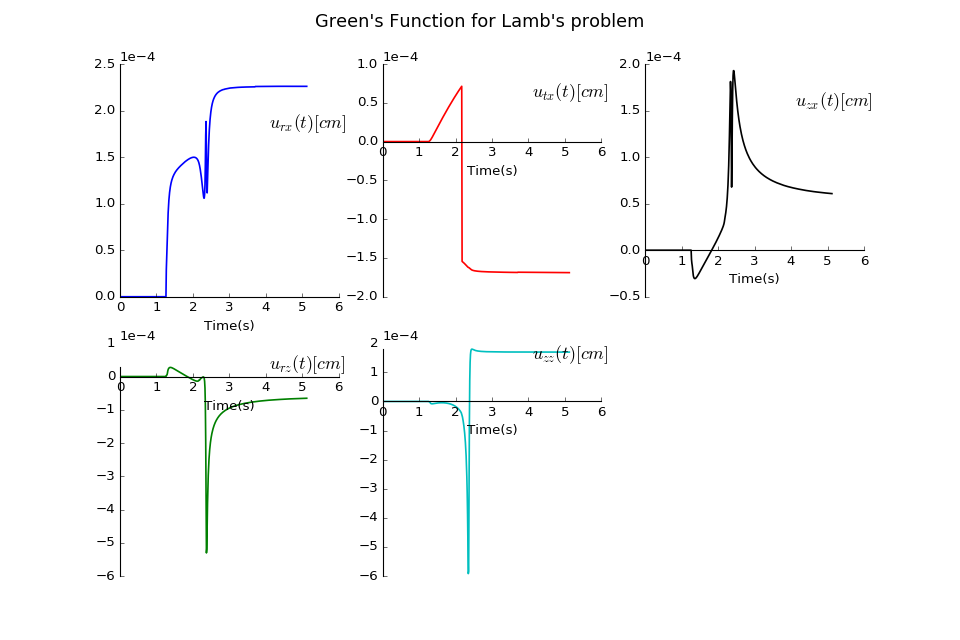

In [3]:
# Plotting
# -----------------------------------------------------------------------------
seis = [u_rx, u_tx, u_zx, u_rz, u_zz]  # Collection of seismograms
labels = ['$u_{rx}(t) [cm]$','$u_{tx}(t)[cm]$','$u_{zx}(t)[cm]$','$u_{rz}(t)[cm]$','$u_{zz}(t)[cm]$']
cols = ['b','r','k','g','c']

# Initialize animated plot
fig = plt.figure(figsize=(12,8), dpi=80)

fig.suptitle("Green's Function for Lamb's problem", fontsize=16)

plt.ion() # set interective mode
plt.show()

for i in range(5):              
    st = seis[i]
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(t, st, lw = 1.5, color=cols[i])  
    ax.set_xlabel('Time(s)')
    ax.text(0.8*nt*dt, 0.8*max(st), labels[i], fontsize=16)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

plt.show()

### Convolution

Let $S(t)$ be a general source time function, then the displacent seismogram is given in terms of the Green's function $G$ via

\begin{equation}
u(\mathbf{x},t) = G(\mathbf{x},t; \mathbf{x}',t') \ast S(t)
\end{equation}

#### Exercise
Compute the convolution of the source time function 'ricker' with the Green's function of a Vertical displacement due to vertical loads. Plot the resulting displacement.

<IPython.core.display.Javascript object>


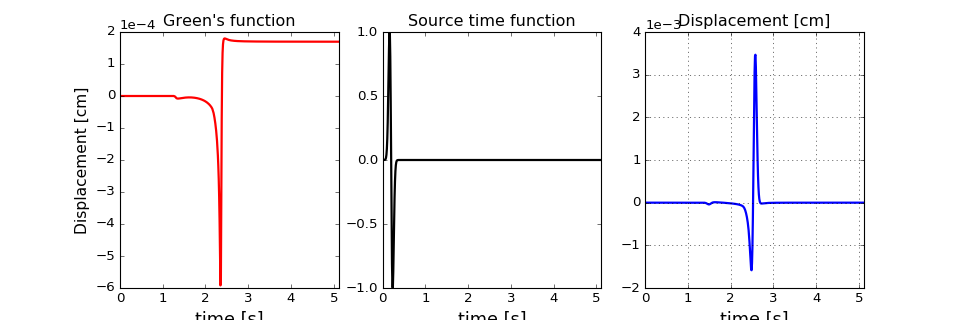

In [4]:
# call the source time function
T = 1/5   # Period
src = ricker(dt,T)

# Normalize source time function
src = src/max(src)

# Initialize source time function
f = np.zeros(nt)
f[0:int(2 * T/dt)] = src

# Compute convolution
u = np.convolve(u_zz, f)
u = u[0:nt]

# ---------------------------------------------------------------
# Plot Seismogram
# ---------------------------------------------------------------
fig = plt.figure(figsize=(12,4), dpi=80)

plt.subplot(1,3,1)
plt.plot(t, u_zz, color='r', lw=2)
plt.title('Green\'s function')
plt.xlabel('time [s]', size=16)
plt.ylabel('Displacement [cm]', size=14)
plt.xlim([0,nt*dt])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(1,3,2)
plt.plot(t, f, color='k', lw=2)
plt.title('Source time function')
plt.xlabel('time [s]', size=16)
plt.xlim([0,nt*dt])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(1,3,3)
plt.plot(t, u, color='b', lw=2)
plt.title('Displacement [cm]')
plt.xlabel('time [s]', size=16)
plt.xlim([0,nt*dt]) 
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(True)
plt.show()